In [97]:
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [98]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'districting-data\\'
filename = 'MT_county.json'

G = read_graph_from_json( filename )

for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001'] # population of county
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']  # longitude of county's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']  # latitude of county's center

In [99]:
from geopy.distance import geodesic

# create distance dictionary
dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'], G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'], G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [100]:
# Let's impose a 1% population deviation (+/-1%)
deviation = 0.0001

import math
k = 2          # number of districts
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
#L = math.floor( total_population / k ) #one person deviation
#U = math.ceil( total_population / k )  #one person deviation
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 542086 and U = 542139 and k = 2


In [101]:
import gurobipy as gp
from gurobipy import GRB

In [102]:
m.reset()

Discarded solution information


In [103]:
# create model 
m = gp.Model()

# create x[i,j] variable which equals one when county i 
#    is assigned to (the district centered at) county j
x = m.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )

In [104]:
# objective is to minimize the moment of inertia: sum (d^2 * p * x over all i and j)
m.setObjective( gp.quicksum( dist[i,j] * dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )

In [105]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [106]:
# add contiguity constraints
import networkx as nx
DG = nx.DiGraph(G)

# add flow variables
#    f[i,j,v] = flow across arc (i,j) that is sent from souce/root v
f = m.addVars( DG.edges, G.nodes ) 

# add constraints saying that if node i is assigned to node j, 
#   then node i must consume one unit of node j's flow
m.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node i can receive flow of type j 
#   only if node i is assigned to node j
M = G.number_of_nodes() - 1
m.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node j cannot receive flow of its own type
m.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

m.update()

In [107]:
# solve, making sure to set a 0.00% MIP gap tolerance
m.Params.MIPGap = 0.0

m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 20.6.0 20G165)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0

Optimize a model with 9521 rows, 18592 columns and 67600 nonzeros
Model fingerprint: 0x3abe879a
Variable types: 15456 continuous, 3136 integer (3136 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [7e+05, 3e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 112 rows and 276 columns
Presolve time: 0.07s
Presolved: 9409 rows, 18316 columns, 67042 nonzeros
Variable types: 15180 continuous, 3136 integer (3136 binary)

Root relaxation: objective 1.097822e+10, 1336 iterations, 0.05 seconds (0.09 work units)

    Nodes    |    Current Node    |     Objective Bounds  

In [108]:
# print the objective value
print(m.objVal)

# retrieve the districts and their populations
#    but first get the district "centers"

centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

11738212887.400978
District 0 has population 542125 and contains counties ['Big Horn', 'Custer', 'Richland', 'Wibaux', 'Golden Valley', 'Carbon', 'Toole', 'Blaine', 'Park', 'Roosevelt', 'Fallon', 'McCone', 'Stillwater', 'Dawson', 'Powder River', 'Hill', 'Treasure', 'Yellowstone', 'Wheatland', 'Valley', 'Petroleum', 'Phillips', 'Sheridan', 'Daniels', 'Prairie', 'Musselshell', 'Meagher', 'Rosebud', 'Sweet Grass', 'Garfield', 'Carter', 'Gallatin', 'Liberty', 'Cascade']

District 1 has population 542100 and contains counties ['Broadwater', 'Sanders', 'Lincoln', 'Granite', 'Judith Basin', 'Powell', 'Teton', 'Glacier', 'Lake', 'Mineral', 'Jefferson', 'Deer Lodge', 'Ravalli', 'Missoula', 'Madison', 'Beaverhead', 'Chouteau', 'Lewis and Clark', 'Pondera', 'Silver Bow', 'Flathead', 'Fergus']



In [109]:
# Let's draw it on a map
import geopandas as gpd

In [110]:
# Read Oklahoma county shapefile from "OK_county.shp"
#filepath = 'districting-data\\'
filename = 'MT_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filename )

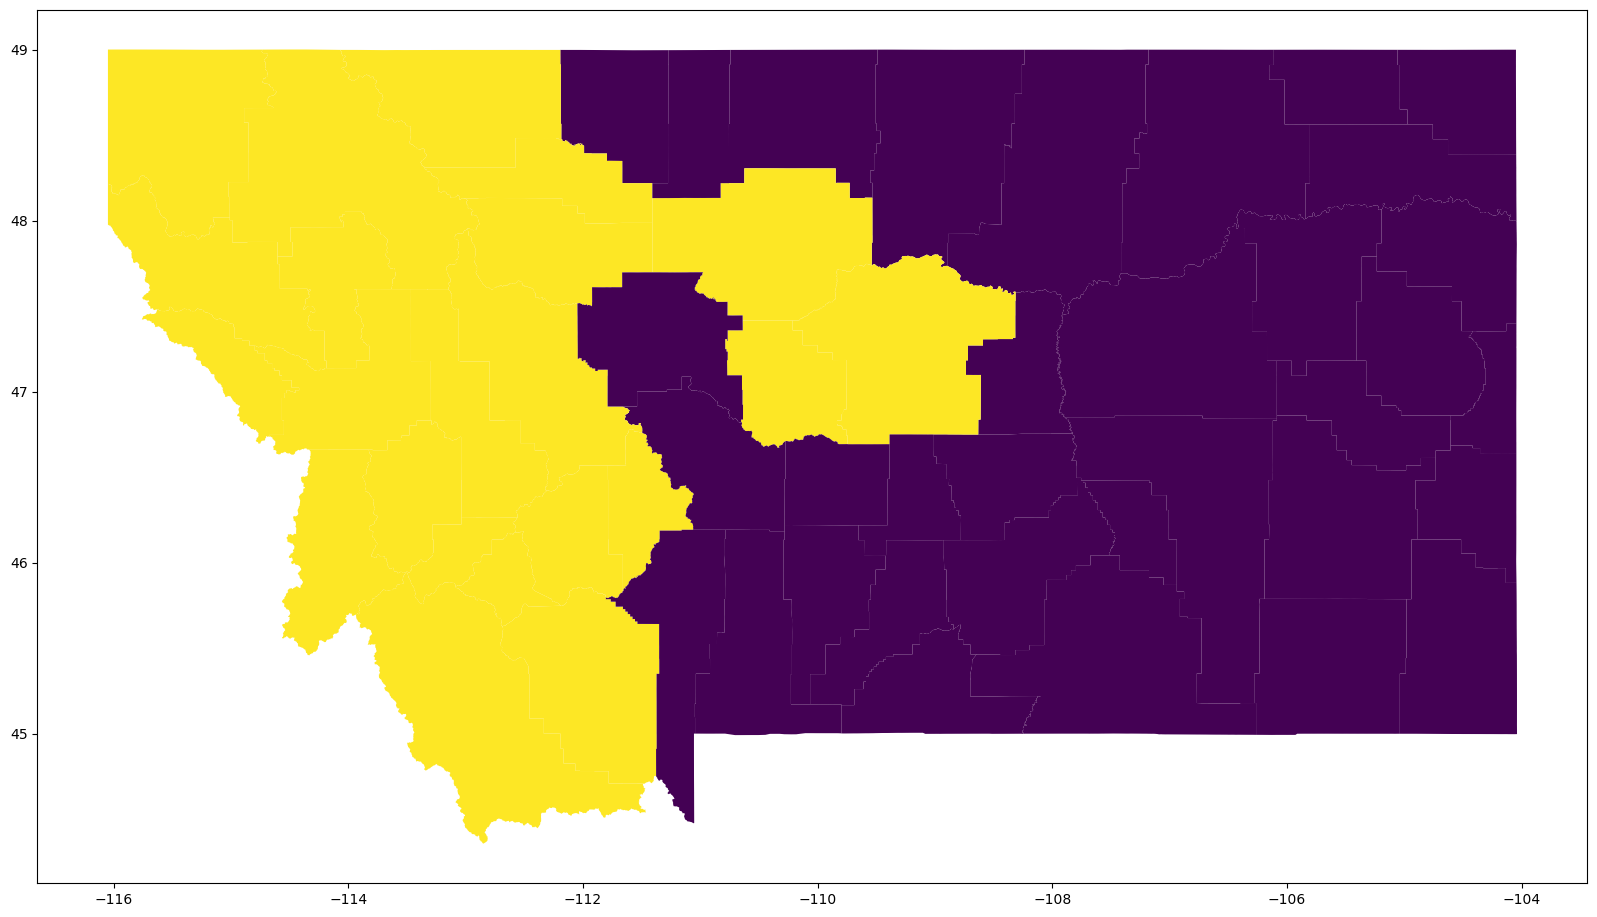

In [111]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment',figsize=(20,30)).get_figure()